In [18]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch.nn as nn
!pip install torchinfo | tail -n 1
from torchinfo import summary
!pip install torchviz | tail -1
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import torch
! pip install japanize_matplotlib
import japanize_matplotlib

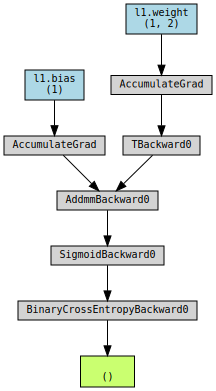

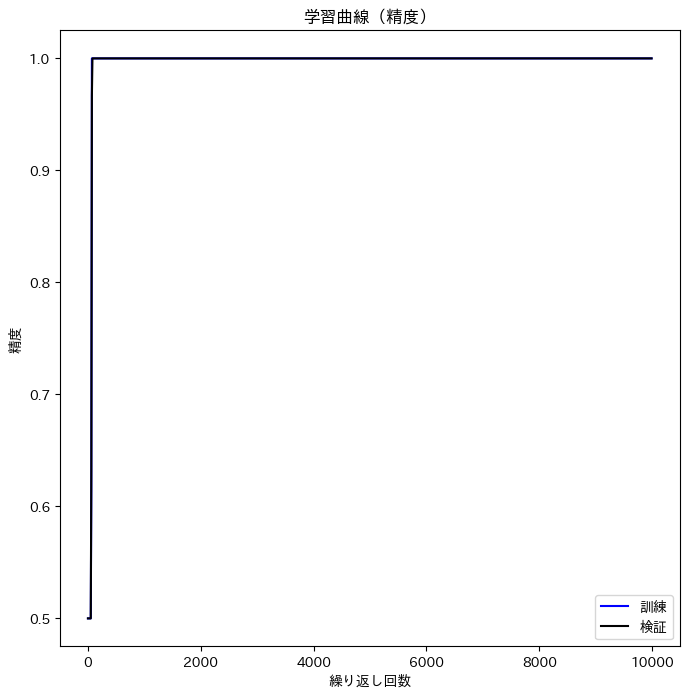

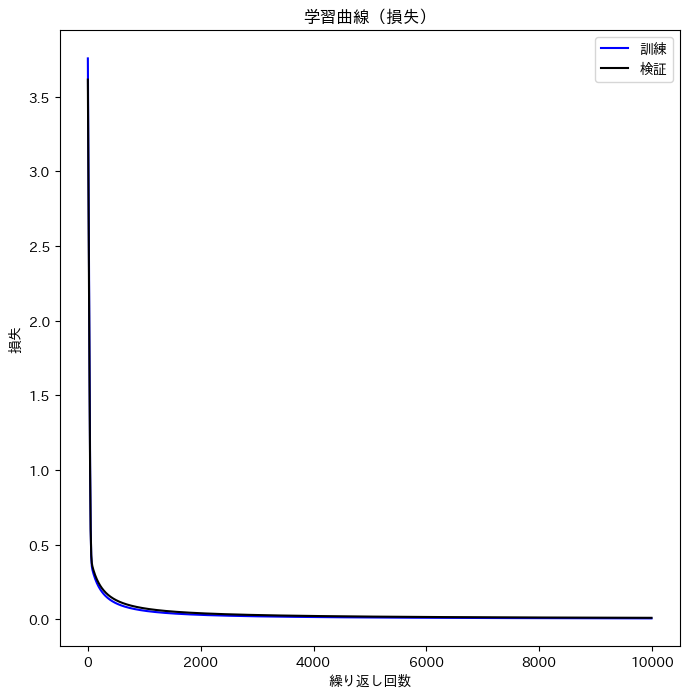

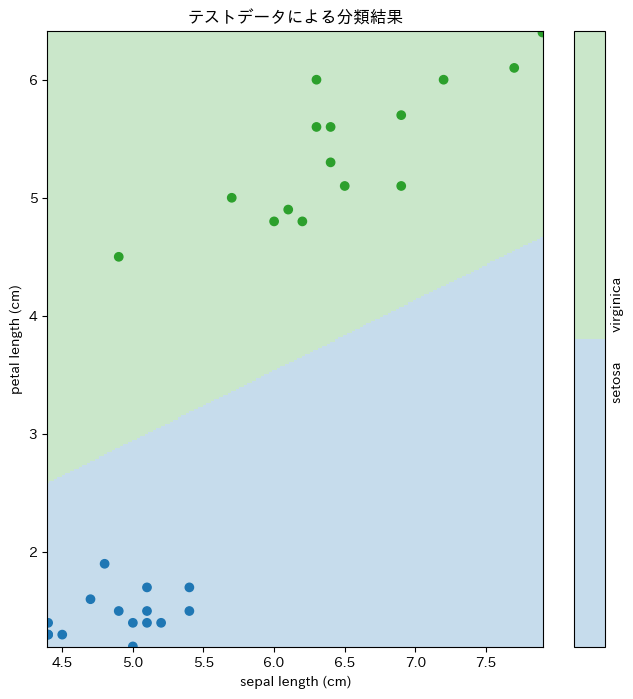

In [30]:
iris = load_iris()

x_org, y_org = iris.data, iris.target

x_data = iris.data[(y_org == 0) | (y_org == 2)][:, [0, 2]]
y_data = iris.target[(y_org == 0) | (y_org == 2)]

y_data = np.where(y_data == 0, 0, 1)

x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    train_size = 70,
    random_state = 123
)

n_input = x_train.shape[1]
n_output = 1

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        return x2


net = Net(n_input, n_output)

criterion = nn.BCELoss()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()
labels1 = labels.view((-1,1))
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()
labels1_test = labels_test.view((-1,1))

output = net(inputs)
loss = criterion(output, labels1)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

lr = 0.01
net = Net(n_input, n_output)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

num_epochs = 10000
history = np.zeros((0,5))

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels1)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    predicted = torch.where(outputs < 0.5, 0, 1)
    train_acc = (predicted == labels1).sum() / len(labels1)

    output_test = net(inputs_test)
    loss_test = criterion(output_test, labels1_test)
    val_loss = loss_test.item()
    predicted_test = torch.where(output_test < 0.5, 0, 1)
    val_acc = (predicted_test == labels1_test).sum() / len(labels1_test)

    if epoch % 10 == 0:
        history = np.vstack((history, np.array([epoch, train_loss, train_acc, val_loss, val_acc])))


plt.figure(figsize=(8,8))
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線（精度）')
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.legend()
plt.show()

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()

def decision(x):
    return -(bias + weight[0,0] * x) / weight[0,1]


def plot_region(model, X, Y, color_idx, xlabel, ylabel, feature0, feature1, title, colorbar=False):
    two_color = np.where(color_idx == min(set(color_idx)), 0, 1)

    cmap_dots  = ListedColormap(['#1f77b4', '#2ca02c'])
    cmap_fills = ListedColormap(['#c6dcec', '#cae7ca'])
    plt.figure(figsize = (8, 8))

    if model:
        XX, YY = np.meshgrid(np.linspace(X.min(), X.max(), 300),
                             np.linspace(Y.min(), Y.max(), 300))
        pred = model(torch.tensor(np.c_[XX.ravel(), YY.ravel()]).float()).reshape(XX.shape)
        colormesh = plt.pcolormesh(XX, YY, pred.data.numpy(), cmap=cmap_fills, shading="auto")

        if colorbar:
            num = (abs(len(feature0) - len(feature1)) + 1) * 2
            plt.colorbar(colormesh, ticks=[], label=feature0 + ' ' * num + feature1)
        else:
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label=feature0, markerfacecolor=cmap_dots(0 / 1), markersize=8),
                Line2D([0], [0], marker='o', color='w', label=feature1, markerfacecolor=cmap_dots(1 / 1), markersize=8)
            ]
            plt.legend(handles=legend_elements)

        plt.scatter(X, Y, c=two_color, cmap=cmap_dots)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


plot_region(net, x_test[:,0], x_test[:,1], y_test, iris.feature_names[0], iris.feature_names[2], iris.target_names[0], iris.target_names[2], title = "テストデータによる分類結果", colorbar=True)
